In [84]:
import pandas as pd
import numpy as np

import scipy.stats as st
import pingouin as pg 

import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
users = pd.read_csv("ab_users_data.csv", parse_dates = ['time', 'date'])
products = pd.read_csv("ab_products.csv")
orders = pd.read_csv("ab_orders.csv", parse_dates = ['creation_time'])

In [86]:
users

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0


In [87]:
users.groupby('action').size()

action
cancel_order     214
create_order    4123
dtype: int64

In [88]:
users.value_counts('group')

group
1    2646
0    1691
dtype: int64

In [89]:
users['canceled'] = users['order_id']\
.isin(users.query('action == "cancel_order"').order_id)\
.astype(int)
users

,user_id,order_id,action,time,date,group,canceled
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,0
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,0
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,0
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,0
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,0


---
### H0: Количество отмен заказов в новой и старой версиях не отличается

In [90]:
pg.chi2_independence(users.query('action == "create_order"'), x = 'group', y = 'canceled')

(canceled            0           1
 group                            
 0         1525.486539   83.513461
 1         2383.513461  130.486539,
 canceled       0      1
 group                  
 0         1526.5   82.5
 1         2382.5  131.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.021274  1.0  0.884034  0.002272  0.052441
 1        cressie-read  0.666667  0.021284  1.0  0.884008  0.002272  0.052442
 2      log-likelihood  0.000000  0.021304  1.0  0.883954  0.002273  0.052444
 3       freeman-tukey -0.500000  0.021319  1.0  0.883914  0.002274  0.052446
 4  mod-log-likelihood -1.000000  0.021334  1.0  0.883873  0.002275  0.052447
 5              neyman -2.000000  0.021364  1.0  0.883791  0.002276  0.052451)

Принимаем нулевую гипотезу. pvalue > 0.05 Статистически незначимое отличие  
Количество отмен заказов увеличилось не из-за версии , а возможно из-за увеличения количества заказов

---
### H0: Количество заказов на каждого пользователя в новой и старой версиях одинаково

In [91]:
order = users.query('action == "create_order"')\
.groupby(['group','user_id'], as_index = False)\
.size()
order

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1
...,...,...,...
1012,1,1976,5
1013,1,1977,4
1014,1,1978,7
1015,1,1979,6


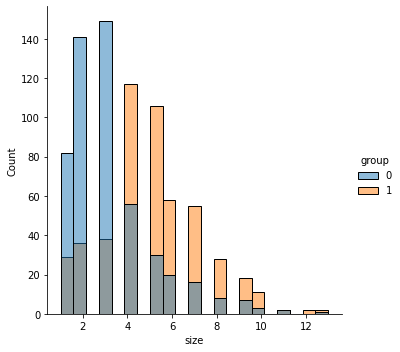

In [92]:
sns.displot(order, x = 'size', hue = 'group')

In [93]:
pg.ttest(x = order.query('group == 1')['size'], y = order.query('group == 0')['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.485157,988.435475,two-sided,2.907783e-43,"[1.63, 2.14]",0.910119,7.663e+39,1.0


Отвергаем нулевую гипотезу. pvalue < 0.05 Статистически значимо количество заказов различаются  
Количество заказов на каждого пользователя в новой версии больше примерно на примерно 2

---
### H0: Количество продуктов на каждого пользователя в новой и старой версиях одинаково

In [102]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}"


In [123]:
orders_users = pd.merge(users.query('action == "create_order"'), orders, on = 'order_id')
orders_users

,user_id,order_id,action,time,date,group,canceled,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,0,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,0,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,1,2022-08-26 00:02:56,"{74, 6}"
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,0,2022-08-26 00:03:37,"{20, 45, 67, 26}"
...,...,...,...,...,...,...,...,...,...
4118,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,0,2022-09-08 23:13:03,"{84, 8, 24}"
4119,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,0,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4120,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,0,2022-09-08 23:22:27,"{60, 41, 46}"
4121,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,0,2022-09-08 23:29:06,"{9, 62, 77}"


In [124]:
orders_users['product_ids'] = orders_users.product_ids.str.strip('{}').str.split(',')
exploded = orders_users.explode('product_ids')

In [125]:
exploded.head()

,user_id,order_id,action,time,date,group,canceled,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0,2022-08-26 00:00:19,75
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0,2022-08-26 00:00:19,22
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0,2022-08-26 00:00:19,53
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,0,2022-08-26 00:00:19,84
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,0,2022-08-26 00:02:21,56


In [116]:
product = exploded.groupby(['group', 'order_id'], as_index = False).size()
product

,group,order_id,size
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4
...,...,...,...
4118,1,59220,4
4119,1,59250,3
4120,1,59390,5
4121,1,59422,3


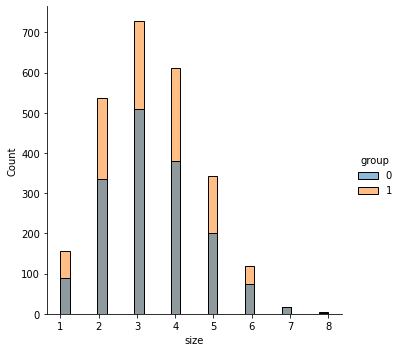

In [118]:
sns.displot(product, x = 'size', hue = 'group')

In [119]:
pg.ttest(x = product.query('group == 1')['size'], y = product.query('group == 0')['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.138556,3469.224056,two-sided,0.889809,"[-0.07, 0.09]",0.004407,0.036,0.052185


Принимаем нулевую гипотезу. pvalue > 0.05 Статистически незначимое отличие  
Количество заказанных продуктов больше, возможно потому что заказов пользователей новой версии больше

---
### H0: Сумма заказа на каждого пользователя в новой и старой версиях одинаково

In [127]:
orders_exp = exploded.rename(columns = {'product_ids':'product_id'}).

In [131]:
orders_exp['product_id'] = orders_exp['product_id'].astype(int)

In [133]:
orders_products = pd.merge(orders_exp, products, on = 'product_id')
orders_products.head()

In [137]:
prices = orders_products.groupby(['group', 'order_id'], as_index = False).price.sum()
prices

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6
...,...,...,...
4118,1,59220,264.2
4119,1,59250,150.3
4120,1,59390,620.8
4121,1,59422,241.2


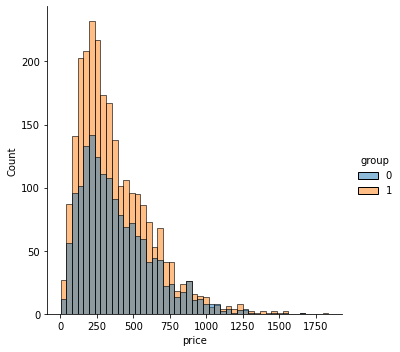

In [138]:
sns.displot(prices, x = 'price', hue = 'group')

In [140]:
pg.ttest(x = prices.query('group == 1')['price'], y = prices.query('group == 0')['price'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.483514,3441.720793,two-sided,0.13803,"[-27.08, 3.75]",0.047301,0.108,0.316351


Принимаем нулевую гипотезу. pvalue > 0.05 Статистически незначимое отличие
Сумма заказа больше, возможно потому что заказов пользователей новой версии больше

### Вывод:  По результатам АВ теста можно сделать вывод, что необходимо включить новую систему.